In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import Spectral6
from bokeh.plotting import figure, gridplot
from bokeh.layouts import row, column
from bokeh.models.tools import HoverTool
from bokeh.transform import transform
output_notebook()

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import pairwise_distances
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import OneHotEncoder

Loading BokehJS ...

# SUBMISSION

In [2]:
sub = pd.read_csv('data/sample_submission.csv')
sub.head()

,id,scalar_coupling_constant
0,4658147,0
1,4658148,0
2,4658149,0
3,4658150,0
4,4658151,0


# TEST

In [2]:
test = pd.read_csv('data/test.csv')
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [3]:
test_names = set(test.molecule_name)

In [4]:
print('shape', test.shape)
print('molecule_name', len(test.molecule_name.unique()))
print('atom_index_0', test.atom_index_0.unique())
print('atom_index_1', test.atom_index_1.unique())
print('types', test.type.unique())

shape (2505542, 5)
molecule_name 45772
atom_index_0 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
  1 26 27 28]
atom_index_1 [ 0  1  3  2  4  5  7  8  6  9 10 11 12 13 15 16 14 17 18 19 20 21 22 23
 24 25 26 27 28]
types ['2JHC' '1JHC' '3JHH' '3JHC' '2JHH' '1JHN' '3JHN' '2JHN']


In [5]:
test.describe()

,id,atom_index_0,atom_index_1
count,2.505542e+06,2.505542e+06,2.505542e+06
mean,5.910918e+06,1.335449e+01,5.877949e+00
std,7.232878e+05,3.272209e+00,4.992313e+00
min,4.658147e+06,1.000000e+00,0.000000e+00
25%,5.284532e+06,1.100000e+01,2.000000e+00
50%,5.910918e+06,1.300000e+01,5.000000e+00
75%,6.537303e+06,1.600000e+01,8.000000e+00
max,7.163688e+06,2.800000e+01,2.800000e+01


In [6]:
test.type.value_counts()

3JHC    811999
2JHC    613138
1JHC    380609
3JHH    317435
2JHH    203126
3JHN     90616
2JHN     64424
1JHN     24195
Name: type, dtype: int64

In [7]:
type_counts = pd.DataFrame(test.type.value_counts())
type_counts.columns = ['counts']
type_counts.sort_index(inplace=True)
type_source = ColumnDataSource(data=type_counts)

zero_counts = pd.DataFrame(test.atom_index_0.value_counts())
zero_counts.columns = ['counts']
zero_counts.sort_index(inplace=True)
zero_counts.index = [str(i) for i in zero_counts.index]

zero_source = ColumnDataSource(data=zero_counts)


one_counts = pd.DataFrame(test.atom_index_1.value_counts())
one_counts.columns = ['counts']
one_counts.sort_index(inplace=True)
one_counts.index = [str(i) for i in one_counts.index]
one_source = ColumnDataSource(data=one_counts)

t = figure(x_range=list(type_counts.index), y_range=(0, type_counts.values.max()), 
           plot_height=250, plot_width=430, title="type",
           toolbar_location=None, tools="")
t.vbar(x='index', top='counts', width=0.9, source=type_source)
t.xgrid.grid_line_color=None
t.add_tools(HoverTool(tooltips=[('', '@index'), ('', '@counts')], mode='vline'))

z = figure(x_range=list(zero_counts.index), y_range=(0, zero_counts.values.max()), 
           plot_height=250, plot_width=430, title="atom_index_0",
           toolbar_location=None, tools="")
z.vbar(x='index', top='counts', width=0.9, source=zero_source)
z.xgrid.grid_line_color=None
z.add_tools(HoverTool(tooltips=[('atom', '@index'), ('', '@counts')], mode='vline'))

o = figure(x_range=list(one_counts.index), y_range=(0, one_counts.values.max()), 
           plot_height=250, plot_width=430, title="atom_index_1",
           toolbar_location=None, tools="")
o.vbar(x='index', top='counts', width=0.9, source=one_source)
o.xgrid.grid_line_color=None
o.add_tools(HoverTool(tooltips=[('atom', '@index'), ('', '@counts')], mode='vline'))

show(gridplot([[row(t, z)], [o]]))

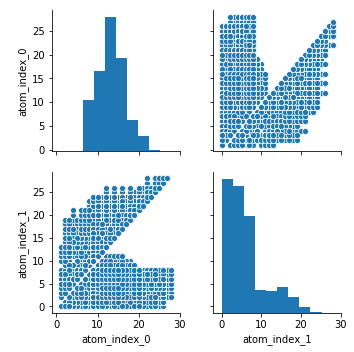

In [8]:
sns.pairplot(test[['atom_index_0', 'atom_index_1']])

# TRAIN

In [3]:
train = pd.read_csv('data/train.csv')

In [10]:
train_names = set(train.molecule_name)

In [11]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [12]:
print('shape', train.shape)
print('types', train.type.unique())
print('atom_index_0', train.atom_index_0.unique())
print('atom_index_1', train.atom_index_1.unique())
print('molecule names', len(train.molecule_name.unique()))

shape (4658147, 6)
types ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']
atom_index_0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26  0 27 28]
atom_index_1 [ 0  2  3  4  1  5  6  7  8  9 10 11 12 13 14 15 16 18 19 17 20 21 22 24
 25 23 26 27 28]
molecule names 85003


In [13]:
set(test.molecule_name).intersection(set(train.molecule_name))

set()

In [14]:
train.isnull().values.any()

False

In [15]:
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,2.329073e+06,1.335689e+01,5.883966e+00,1.592165e+01
std,1.344691e+06,3.267712e+00,4.993943e+00,3.494198e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,1.164536e+06,1.100000e+01,2.000000e+00,-2.549780e-01
50%,2.329073e+06,1.300000e+01,5.000000e+00,2.281130e+00
75%,3.493610e+06,1.600000e+01,8.000000e+00,7.390655e+00
max,4.658146e+06,2.800000e+01,2.800000e+01,2.048800e+02


In [16]:
type_counts = pd.DataFrame(train.type.value_counts())
type_counts.columns = ['counts']
type_counts.sort_index(inplace=True)
type_source = ColumnDataSource(data=type_counts)

zero_counts = pd.DataFrame(train.atom_index_0.value_counts())
zero_counts.columns = ['counts']
zero_counts.sort_index(inplace=True)
zero_counts.index = [str(i) for i in zero_counts.index]
zero_source = ColumnDataSource(data=zero_counts)

one_counts = pd.DataFrame(train.atom_index_1.value_counts())
one_counts.columns = ['counts']
one_counts.sort_index(inplace=True)
one_counts.index = [str(i) for i in one_counts.index]
one_source = ColumnDataSource(data=one_counts)

scalar_sourse = ColumnDataSource(data=train)

t = figure(x_range=list(type_counts.index), y_range=(0, type_counts.values.max()), 
           plot_height=250, plot_width=430, title="type",
           toolbar_location=None, tools="")
t.vbar(x='index', top='counts', width=0.9, source=type_source)
t.xgrid.grid_line_color=None
t.add_tools(HoverTool(tooltips=[('', '@index'), ('', '@counts')], mode='vline'))

z = figure(x_range=list(zero_counts.index), y_range=(0, zero_counts.values.max()), 
           plot_height=250, plot_width=430, title="atom_index_0",
           toolbar_location=None, tools="")
z.vbar(x='index', top='counts', width=0.9, source=zero_source)
z.xgrid.grid_line_color=None
z.add_tools(HoverTool(tooltips=[('atom', '@index'), ('', '@counts')], mode='vline'))

o = figure(x_range=list(one_counts.index), y_range=(0, one_counts.values.max()), 
           plot_height=250, plot_width=430, title="atom_index_1",
           toolbar_location=None, tools="")
o.vbar(x='index', top='counts', width=0.9, source=one_source)
o.xgrid.grid_line_color=None
o.add_tools(HoverTool(tooltips=[('atom', '@index'), ('', '@counts')], mode='vline'))

s = figure(plot_height=250, plot_width=430, title="scalar",
           toolbar_location=None, tools="")
hist, edges = np.histogram(train.scalar_coupling_constant, 
                           bins=int(1+3.322*np.log(train.shape[0])))
s.quad(top='h', bottom=0, left='l', right='r',
           line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
s.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

show(gridplot([[row(t, z)], [row(o, s)]]))

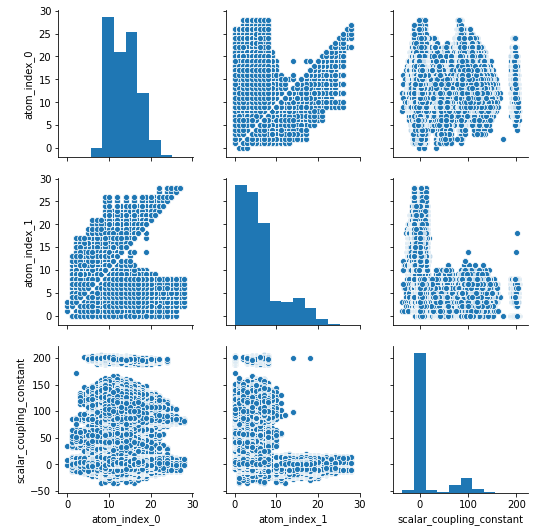

In [63]:
sns.pairplot(train[['atom_index_0',  'atom_index_1', 'type', 'scalar_coupling_constant']])

In [17]:
OneHotEncoder(sparse=False).fit_transform(np.array(train.type).reshape(-1, 1))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [6]:
random_state = 42
cols = ['atom_index_0',  'atom_index_1']
ids = [str(i) for i in train.index]
vals = np.array(train[cols])
types = OneHotEncoder(sparse=False).fit_transform(np.array(train.type).reshape(-1, 1))
vals = np.hstack((vals, types))
spa = SparseRandomProjection(2, random_state=random_state)
pca = PCA(2, random_state=random_state)
tru = TruncatedSVD(2, random_state=random_state)
tsne = TSNE(2, random_state=random_state)
mds = MDS(2, random_state=random_state)
mds_cos = MDS(2, dissimilarity='precomputed', random_state=random_state)

In [4]:
def plot_scal(proj, cos=False):
    if not cos:
        points = proj.fit_transform(vals)
    else:
        points = proj.fit_transform(pairwise_distances(vals, metric='cosine'))
    source = ColumnDataSource(data=dict(x=[i[0] for i in points], y=[i[1] for i in points], ids=ids, 
                                        v=np.array(train.scalar_coupling_constant)))
    color_mapper = LinearColorMapper(palette='Viridis256', 
                                     low=train.scalar_coupling_constant.values.min(), 
                                     high=train.scalar_coupling_constant.values.max())
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0, 0))
    p = figure(plot_width=400, plot_height=400, tools='')
    circles = p.circle(x='x', y='y', color=transform('v', color_mapper), fill_alpha=0.5, source=source)
    #p.add_tools(HoverTool(tooltips=[('', '@ids')], renderers=[circles]))
    p.add_layout(color_bar, 'right')
    show(p)

In [7]:
plot_scal(spa)

MemoryError: 

# STRUCTURES

In [8]:
structures = pd.read_csv('data/structures.csv')
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [9]:
structures[structures.molecule_name=='dsgdb9nsd_000002']

,molecule_name,atom_index,atom,x,y,z
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543


In [10]:
structures_names = set(structures.molecule_name)

In [11]:
print('shape', structures.shape)
print('molecule names', len(structures.molecule_name.unique()))
print('atom_index', structures.atom_index.unique())
print('atom', structures.atom.unique())

shape (2358657, 6)
molecule names 130775
atom_index [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
atom ['C' 'H' 'N' 'O' 'F']


In [12]:
structures.describe()

,atom_index,x,y,z
count,2.358657e+06,2.358657e+06,2.358657e+06,2.358657e+06
mean,8.757349e+00,9.489178e-02,-3.337381e-01,6.241504e-02
std,5.592487e+00,1.655271e+00,1.989152e+00,1.445870e+00
min,0.000000e+00,-9.234889e+00,-9.933938e+00,-9.134765e+00
25%,4.000000e+00,-8.746097e-01,-1.826156e+00,-8.424896e-01
50%,9.000000e+00,5.183615e-02,-4.035932e-01,1.093207e-02
75%,1.300000e+01,1.116101e+00,1.373660e+00,9.394357e-01
max,2.800000e+01,9.382240e+00,1.018196e+01,7.894733e+00


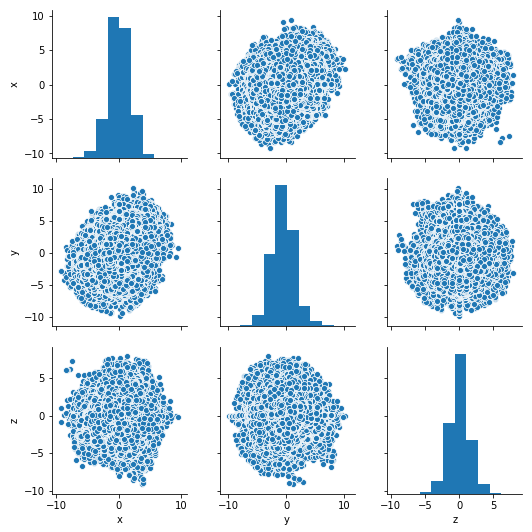

In [34]:
sns.pairplot(structures[['x', 'y', 'z']])

In [13]:
ai = pd.DataFrame(structures.atom_index.value_counts())
ai.columns = ['counts']
ai.sort_index(inplace=True)
ai.index = [str(i) for i in ai.index]
ai_source = ColumnDataSource(data=ai)
aif = figure(x_range=list(ai.index),  
            plot_height=250, plot_width=430, title="atom_index",
            toolbar_location=None, tools="")
aif.vbar(x='index', top='counts', width=0.9, source=ai_source)
aif.xgrid.grid_line_color=None
aif.add_tools(HoverTool(tooltips=[('', '@index'), ('', '@counts')], mode='vline'))

a = pd.DataFrame(structures.atom.value_counts())
a.columns = ['counts']
a_source = ColumnDataSource(data=a)
af = figure(x_range=list(a.index),  
            plot_height=250, plot_width=430, title="atom",
            toolbar_location=None, tools="")
af.vbar(x='index', top='counts', width=0.9, source=a_source)
af.xgrid.grid_line_color=None
af.add_tools(HoverTool(tooltips=[('', '@index'), ('', '@counts')], mode='vline'))
show(row(aif, af))

x = figure(plot_height=250, plot_width=430, title="x",
           toolbar_location=None, tools="")
hist, edges = np.histogram(structures.x, 
                           bins=int(1+3.322*np.log(structures.shape[0])))
x.quad(top='h', bottom=0, left='l', right='r',
       line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
x.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

y = figure(plot_height=250, plot_width=430, title="y",
           toolbar_location=None, tools="")
hist, edges = np.histogram(structures.y, 
                           bins=int(1+3.322*np.log(structures.shape[0])))
y.quad(top='h', bottom=0, left='l', right='r',
       line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
y.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(row(x, y))

z = figure(plot_height=250, plot_width=430, title="z",
           toolbar_location=None, tools="")
hist, edges = np.histogram(structures.z, 
                           bins=int(1+3.322*np.log(structures.shape[0])))
z.quad(top='h', bottom=0, left='l', right='r',
       line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
z.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(z)

# DIPOLE

In [2]:
dipole = pd.read_csv('data/dipole_moments.csv')
dipole.head()

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256
2,dsgdb9nsd_000003,0.0000,0.0,-1.8511
3,dsgdb9nsd_000005,0.0000,0.0,-2.8937
4,dsgdb9nsd_000007,0.0000,0.0,0.0000


In [12]:
dipole_names = set(dipole.molecule_name)

In [20]:
print(dipole.shape)
print('molecule name', len(dipole.molecule_name.unique()))

(85003, 4)
molecule name 85003


In [21]:
dipole.describe()

,X,Y,Z
count,85003.000000,85003.000000,85003.000000
mean,-0.019937,0.093764,0.252982
std,2.283738,1.739395,1.027573
min,-22.958000,-9.252300,-6.028500
25%,-1.363250,-0.941950,-0.247750
50%,-0.000100,0.081400,0.117600
75%,1.311000,1.166750,0.902050
max,21.873800,13.005600,6.880100


In [3]:
x = figure(plot_height=250, plot_width=430, title="x",
           toolbar_location=None, tools="")
hist, edges = np.histogram(dipole.X, 
                           bins=int(1+3.322*np.log(dipole.shape[0])))
x.quad(top='h', bottom=0, left='l', right='r',
       line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
x.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

y = figure(plot_height=250, plot_width=430, title="y",
           toolbar_location=None, tools="")
hist, edges = np.histogram(dipole.Y, 
                           bins=int(1+3.322*np.log(dipole.shape[0])))
y.quad(top='h', bottom=0, left='l', right='r',
       line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
y.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(row(x, y))

z = figure(plot_height=250, plot_width=430, title="z",
           toolbar_location=None, tools="")
hist, edges = np.histogram(dipole.Z, 
                           bins=int(1+3.322*np.log(dipole.shape[0])))
z.quad(top='h', bottom=0, left='l', right='r',
       line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
z.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(z)

In [33]:
dipole['molecule_name'] = [int(i.split('_')[1]) for i in dipole.molecule_name]
dipole.corr()

,molecule_name,X,Y,Z
molecule_name,1.000000,-0.001103,-0.027490,-0.019102
X,-0.001103,1.000000,-0.012428,-0.023721
Y,-0.027490,-0.012428,1.000000,0.014503
Z,-0.019102,-0.023721,0.014503,1.000000


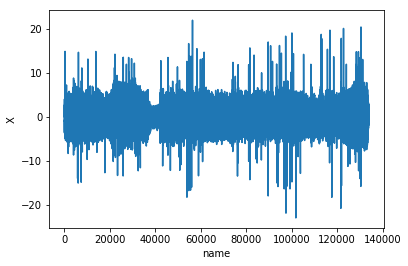

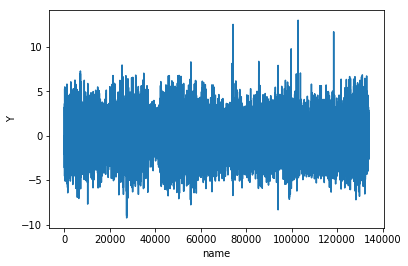

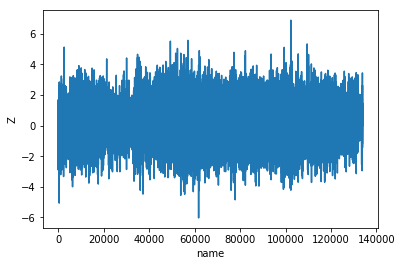

In [12]:
names = [int(i.split('_')[1]) for i in dipole.molecule_name]
for i in ['X', 'Y', 'Z']:
    vals = list(dipole[i])
    plt.plot(names, vals)
    plt.xlabel('name')
    plt.ylabel(i)
    plt.show()

# MAGNETIC

In [4]:
magnetic = pd.read_csv('data/magnetic_shielding_tensors.csv')
magnetic.head()

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3150,0.0000,-0.0001,0.0000,195.3170,0.0007,-0.0001,0.0007,195.3170
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013


In [14]:
magnetic_names = set(magnetic.molecule_name)

In [29]:
magnetic.tail()

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
1533532,dsgdb9nsd_133884,13,38.9961,3.3026,-0.0001,-1.7562,26.1603,0.0000,0.0001,0.0000,24.1113
1533533,dsgdb9nsd_133884,14,26.9291,0.6933,-0.8246,1.9653,34.1115,-4.9683,-0.7688,-5.1307,29.9158
1533534,dsgdb9nsd_133884,15,26.9291,0.6933,0.8246,1.9654,34.1115,4.9683,0.7688,5.1307,29.9158
1533535,dsgdb9nsd_133884,16,28.9460,0.0146,2.5359,-2.0440,24.9160,-1.7686,1.8798,0.9608,31.6697
1533536,dsgdb9nsd_133884,17,30.1753,-6.4689,-5.5474,-3.8417,30.4761,6.3612,-1.5380,4.0582,29.4963


In [28]:
print(magnetic.shape)
print('molecule name', len(magnetic.molecule_name.unique()))
print('atom index', magnetic.atom_index.unique())

(1533537, 11)
molecule name 85003
atom index [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


In [5]:
ai = pd.DataFrame(magnetic.atom_index.value_counts())
ai.columns = ['counts']
ai.sort_index(inplace=True)
ai.index = [str(i) for i in ai.index]
ai_source = ColumnDataSource(data=ai)
aif = figure(x_range=list(ai.index),  
            plot_height=250, plot_width=430, title="atom_index",
            toolbar_location=None, tools="")
aif.vbar(x='index', top='counts', width=0.9, source=ai_source)
aif.xgrid.grid_line_color=None
aif.add_tools(HoverTool(tooltips=[('', '@index'), ('', '@counts')], mode='vline'))

xx = figure(plot_height=250, plot_width=430, title="xx",
            toolbar_location=None, tools="")
hist, edges = np.histogram(magnetic.XX, 
                           bins=int(1+3.322*np.log(magnetic.shape[0])))
xx.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
xx.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(row(aif, xx))

yx = figure(plot_height=250, plot_width=430, title="yx",
            toolbar_location=None, tools="")
hist, edges = np.histogram(magnetic.YX, 
                           bins=int(1+3.322*np.log(magnetic.shape[0])))
yx.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
yx.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

zx = figure(plot_height=250, plot_width=430, title="zx",
            toolbar_location=None, tools="")
hist, edges = np.histogram(magnetic.ZX, 
                           bins=int(1+3.322*np.log(magnetic.shape[0])))
zx.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
zx.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(row(yx, zx))

xy = figure(plot_height=250, plot_width=430, title="xy",
            toolbar_location=None, tools="")
hist, edges = np.histogram(magnetic.XY, 
                           bins=int(1+3.322*np.log(magnetic.shape[0])))
xy.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
xy.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

yy = figure(plot_height=250, plot_width=430, title="yy",
            toolbar_location=None, tools="")
hist, edges = np.histogram(magnetic.YY, 
                           bins=int(1+3.322*np.log(magnetic.shape[0])))
yy.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
yy.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(row(xy, yy))

zy = figure(plot_height=250, plot_width=430, title="zy",
            toolbar_location=None, tools="")
hist, edges = np.histogram(magnetic.ZY, 
                           bins=int(1+3.322*np.log(magnetic.shape[0])))
zy.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
zy.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

xz = figure(plot_height=250, plot_width=430, title="xz",
            toolbar_location=None, tools="")
hist, edges = np.histogram(magnetic.XZ, 
                           bins=int(1+3.322*np.log(magnetic.shape[0])))
xz.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
xz.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(row(zy, xz))

yz = figure(plot_height=250, plot_width=430, title="yz",
            toolbar_location=None, tools="")
hist, edges = np.histogram(magnetic.YZ, 
                           bins=int(1+3.322*np.log(magnetic.shape[0])))
yz.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
yz.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

zz = figure(plot_height=250, plot_width=430, title="zz",
            toolbar_location=None, tools="")
hist, edges = np.histogram(magnetic.ZZ, 
                           bins=int(1+3.322*np.log(magnetic.shape[0])))
zz.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
zz.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(row(yz, zz))

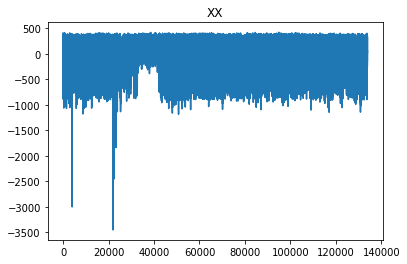

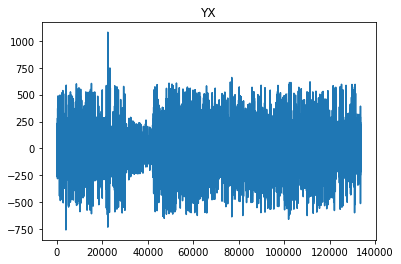

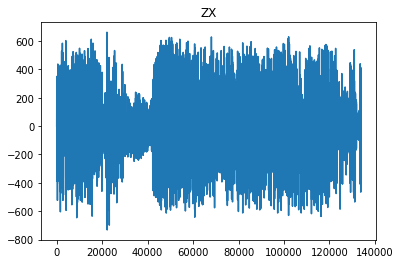

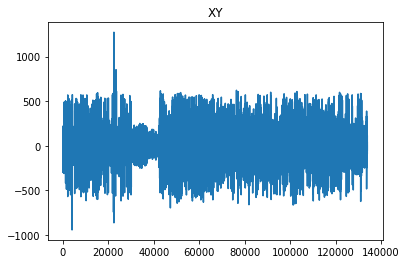

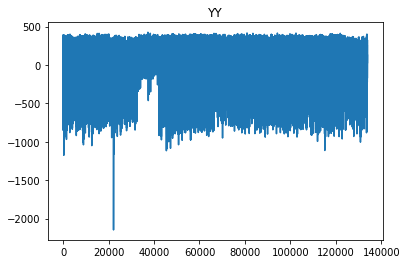

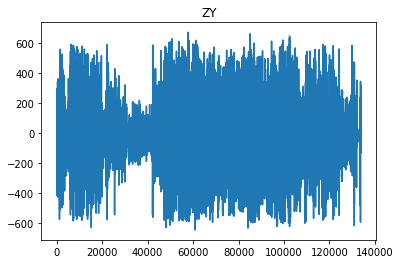

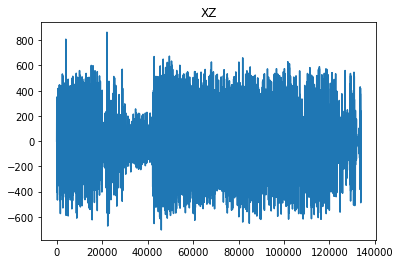

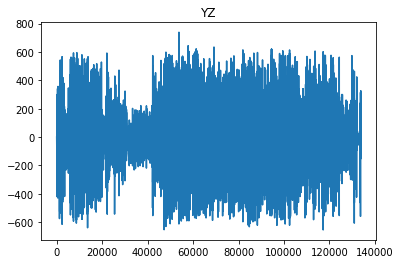

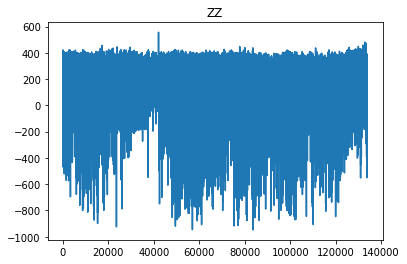

In [15]:
names = [int(i.split('_')[1]) for i in magnetic.molecule_name]
for i in ['XX', 'YX', 'ZX', 'XY', 'YY', 'ZY', 'XZ', 'YZ', 'ZZ']:
    plt.plot(names, magnetic[i])
    plt.title(i)
    plt.show()

# MULLIKEN

In [6]:
mulliken = pd.read_csv('data/mulliken_charges.csv')
mulliken.head()

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921
2,dsgdb9nsd_000001,2,0.133922
3,dsgdb9nsd_000001,3,0.133923
4,dsgdb9nsd_000001,4,0.133923


In [16]:
mulliken_names = set(mulliken.molecule_name)

In [44]:
print(mulliken.shape)
print('molecule name', len(mulliken.molecule_name.unique()))
print('atom_index', mulliken.atom_index.unique())

(1533537, 3)
molecule name 85003
atom_index [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


In [7]:
ai = pd.DataFrame(mulliken.atom_index.value_counts())
ai.columns = ['counts']
ai.sort_index(inplace=True)
ai.index = [str(i) for i in ai.index]
ai_source = ColumnDataSource(data=ai)
aif = figure(x_range=list(ai.index),  
            plot_height=250, plot_width=430, title="atom_index",
            toolbar_location=None, tools="")
aif.vbar(x='index', top='counts', width=0.9, source=ai_source)
aif.xgrid.grid_line_color=None
aif.add_tools(HoverTool(tooltips=[('', '@index'), ('', '@counts')], mode='vline'))

xx = figure(plot_height=250, plot_width=430, title="charge",
            toolbar_location=None, tools="")
hist, edges = np.histogram(mulliken.mulliken_charge, 
                           bins=int(1+3.322*np.log(mulliken.shape[0])))
xx.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
xx.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(row(aif, xx))

# POTENTIAL

In [8]:
potential = pd.read_csv('data/potential_energy.csv')
potential.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869


In [18]:
potential_names = set(potential.molecule_name)

In [50]:
print(potential.shape)
print('molecule name', len(potential.molecule_name.unique()))

(85003, 2)
molecule name 85003


In [9]:
xx = figure(plot_height=250, plot_width=430, title="energy",
            toolbar_location=None, tools="")
hist, edges = np.histogram(potential.potential_energy, 
                           bins=int(1+3.322*np.log(potential.shape[0])))
xx.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
xx.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(xx)

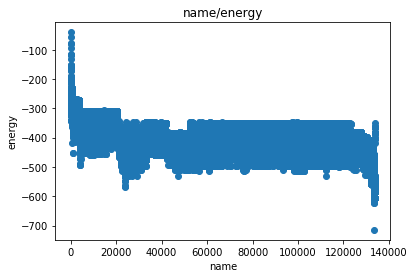

In [39]:
plt.scatter([int(i.split('_')[1]) for i in potential.molecule_name], potential.potential_energy)
plt.title('name/energy')
plt.xlabel('name')
plt.ylabel('energy')
plt.show()

# COUPLING

In [10]:
coupling = pd.read_csv('data/scalar_coupling_contributions.csv')
coupling.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


In [20]:
coupling_names = set(coupling.molecule_name)

In [54]:
print(coupling.shape)
print('molecule name', len(coupling.molecule_name.unique()))
print('ai0', coupling.atom_index_0.unique())
print('ai1', coupling.atom_index_1.unique())
print('type', coupling.type.unique())

(4658147, 8)
molecule name 85003
ai0 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26  0 27 28]
ai1 [ 0  2  3  4  1  5  6  7  8  9 10 11 12 13 14 15 16 18 19 17 20 21 22 24
 25 23 26 27 28]
type ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']


In [55]:
coupling.describe()

,atom_index_0,atom_index_1,fc,sd,pso,dso
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,1.335689e+01,5.883966e+00,1.569776e+01,8.233637e-02,3.751619e-01,-2.336117e-01
std,3.267712e+00,4.993943e+00,3.441461e+01,1.386516e-01,7.422133e-01,9.296036e-01
min,0.000000e+00,0.000000e+00,-3.722400e+01,-3.184910e+00,-3.288110e+00,-6.856790e+00
25%,1.100000e+01,2.000000e+00,-2.129645e-01,-1.438100e-02,-3.506500e-02,-3.734250e-01
50%,1.300000e+01,5.000000e+00,2.327140e+00,5.072900e-02,1.594810e-01,-6.476600e-02
75%,1.600000e+01,8.000000e+00,7.472885e+00,1.303520e-01,4.350445e-01,1.433210e-01
max,2.800000e+01,2.800000e+01,2.055170e+02,2.296690e+00,8.201530e+00,1.701610e+00


In [11]:
ai0 = pd.DataFrame(coupling.atom_index_0.value_counts())
ai0.columns = ['counts']
ai0.sort_index(inplace=True)
ai0.index = [str(i) for i in ai0.index]
ai0_source = ColumnDataSource(data=ai0)
aif0 = figure(x_range=list(ai0.index),  
            plot_height=250, plot_width=430, title="atom_index_0",
            toolbar_location=None, tools="")
aif0.vbar(x='index', top='counts', width=0.9, source=ai0_source)
aif0.xgrid.grid_line_color=None
aif0.add_tools(HoverTool(tooltips=[('', '@index'), ('', '@counts')], mode='vline'))

ai1 = pd.DataFrame(coupling.atom_index_1.value_counts())
ai1.columns = ['counts']
ai1.sort_index(inplace=True)
ai1.index = [str(i) for i in ai1.index]
ai1_source = ColumnDataSource(data=ai1)
aif1 = figure(x_range=list(ai1.index),  
            plot_height=250, plot_width=430, title="atom_index_1",
            toolbar_location=None, tools="")
aif1.vbar(x='index', top='counts', width=0.9, source=ai1_source)
aif1.xgrid.grid_line_color=None
aif1.add_tools(HoverTool(tooltips=[('', '@index'), ('', '@counts')], mode='vline'))

show(row(aif0, aif1))

fc = figure(plot_height=250, plot_width=430, title="fc",
            toolbar_location=None, tools="")
hist, edges = np.histogram(coupling.fc, 
                           bins=int(1+3.322*np.log(coupling.shape[0])))
fc.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
fc.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

sd = figure(plot_height=250, plot_width=430, title="sd",
            toolbar_location=None, tools="")
hist, edges = np.histogram(coupling.sd, 
                           bins=int(1+3.322*np.log(coupling.shape[0])))
sd.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
sd.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

show(row(fc,sd))

pso = figure(plot_height=250, plot_width=430, title="pso",
            toolbar_location=None, tools="")
hist, edges = np.histogram(coupling.pso, 
                           bins=int(1+3.322*np.log(coupling.shape[0])))
pso.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
pso.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))

dso = figure(plot_height=250, plot_width=430, title="dso",
            toolbar_location=None, tools="")
hist, edges = np.histogram(coupling.dso, 
                           bins=int(1+3.322*np.log(coupling.shape[0])))
dso.quad(top='h', bottom=0, left='l', right='r',
        line_color="white", source=ColumnDataSource(data=dict(h=hist, l=edges[:-1], r=edges[1:])))
dso.add_tools(HoverTool(tooltips=[('left', '@l'), ('right', '@r'), ('', '@h')], mode='vline'))
show(row(pso,dso))

### END

In [21]:
print(len(test_names))
print(len(train_names))
print(len(dipole_names))
print(len(magnetic_names))
print(len(mulliken_names))
print(len(potential_names))
print(len(coupling_names))
print(len(structures_names))

45772
85003
85003
85003
85003
85003
85003
130775


In [22]:
45772+85003

130775

In [26]:
len(structures_names.intersection(train_names))

85003